In [1]:
import requests
import re
import pandas as pd
import random
from string import ascii_lowercase
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [2]:
# Download NLTK stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean text: remove punctuation, stop words, and non-textual elements
def clean_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Split into words
    words = text.split()
    # Remove stop words and non-textual elements
    cleaned_words = [word for word in words if word.lower() not in stop_words]
    # strip underscores
    cleaned_words = [word.strip('_') for word in cleaned_words]
    # remove numbers
    cleaned_words = [word for word in cleaned_words if not word.isnumeric()]
    return ' '.join(cleaned_words)

def find_start_end(text):
    # Find the start and end of the main text
    start_pattern = r"\*\*\* START OF THIS PROJECT GUTENBERG EBOOK .+ \*\*\*"
    end_pattern = r"\*\*\* END OF THIS PROJECT GUTENBERG EBOOK .+ \*\*\*"

    start_match = re.search(start_pattern, text)
    end_match = re.search(end_pattern, text)

    start_idx = start_match.end() if start_match else 0
    end_idx = end_match.start() if end_match else len(text)

    return text[start_idx:end_idx]

def process_book(url, label):
    # Download the book text from the URL
    response = requests.get(url)
    response.encoding = 'utf-8'
    text = response.text

    # Extract the main text between start and end markers
    main_text = find_start_end(text)

    # Clean the main text
    cleaned_text = clean_text(main_text)

    # Extract words from the cleaned text
    words = cleaned_text.split()

    # Split words into partitions of 100 and take 200 random partitions
    partitions = [words[i:i + 100] for i in range(0, len(words), 100)]
    random_partitions = random.sample(partitions, min(200, len(partitions)))

    return [(label, ' '.join(partition)) for partition in random_partitions]

# Updated list of Gutenberg book URLs (Same as before, no change needed here)
book_urls = [
    'https://www.gutenberg.org/files/1342/1342-0.txt',  # Pride and Prejudice by Jane Austen
    'https://www.gutenberg.org/files/768/768-0.txt',    # Wuthering Heights by Emily Brontë
    'https://www.gutenberg.org/files/1260/1260-0.txt',  # Jane Eyre by Charlotte Brontë
    'https://www.gutenberg.org/files/1400/1400-0.txt',  # Great Expectations by Charles Dickens
    'https://www.gutenberg.org/files/145/145-0.txt',    # Middlemarch by George Eliot
    'https://www.gutenberg.org/files/541/541.txt'       # The Age of Innocence by Edith Wharton
]

book_authors = ["Jane Austen", "Emily Bronte", "Charlotte Bronte", "Charles Dickens",  "George Eliot", "Edith Wharton"]


# Process all books
all_partitions = []

for url, label in zip(book_urls, book_authors):
    book_partitions = process_book(url, label)
    all_partitions.extend(book_partitions)

# Convert to DataFrame
partition_df = pd.DataFrame(all_partitions, columns=['Label', 'Words'])

# Serialize DataFrame to CSV
partition_df.to_csv('book_partitions_cleaned.csv', index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

In [59]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

In [26]:
model_objs = [
    OneVsRestClassifier(SVC(kernel="linear")),
    OneVsRestClassifier(SVC(kernel="rbf")),
    OneVsRestClassifier(SVC(kernel="poly")),
    RandomForestClassifier(),
    GaussianNB(),
    KNeighborsClassifier(),
    OneVsOneClassifier(SGDClassifier()),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(random_state=69)
    ]


model_names = [
    "Linear SVC",
    "Gaussian SVC",
    "Polynomial SVC",
    "RandomForestClassifier",
    "Naive Bayes",
    "KNeighborsClassifier",
    "SGDClassifier",
    "DecisionTreeClassifier",
    "AdaBoostClassifier",
    "XGBClassifier",
]

In [27]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

kf = KFold(n_splits=10, shuffle=True, random_state=69)
onehot_encoder = OneHotEncoder(sparse=False, drop='first')

for m_obj, m_name in zip(model_objs, model_names):
  acc_sum = 0
  precision_sum = 0
  recall_sum = 0
  f1_sum = 0
  roc_auc_sum = 0
  for train_index,test_index in kf.split(partition_df[:600]):
    train_data = partition_df.iloc[train_index]
    test_data = partition_df.iloc[test_index]
    X_train = train_data.drop(['Label'], axis=1)
    y_train = train_data['Label']
    X_test = test_data.drop(['Label'], axis=1)
    y_test = test_data['Label']

    # One-hot encoding for the label
    y_train_onehot = onehot_encoder.fit_transform(train_data[['Label']])
    y_test_onehot = onehot_encoder.transform(test_data[['Label']])

    y_train_df = pd.DataFrame(y_train_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))
    y_test_df = pd.DataFrame(y_test_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))

    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['Words'])
    X_test_tfidf = tfidf_vectorizer.transform(X_test['Words'])
    X_train_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    X_test_tfidf = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

    m_obj.fit(X_train_tfidf, y_train_df),
    y_pred = m_obj.predict(X_test_tfidf)
    acc = accuracy_score(y_pred, y_test_df)
    precision = precision_score(y_pred, y_test_df, average='macro')
    recall = recall_score(y_pred, y_test_df, average='macro')
    f1 = f1_score(y_pred, y_test_df, average='macro')
    roc_auc = roc_auc_score(y_test_df, y_pred, average='macro')

    acc_sum+=acc
    precision_sum += precision
    recall_sum += recall
    f1_sum += f1
    roc_auc_sum += roc_auc

  print("MODEL: {}".format(m_name))
  print("Average Accuracy: {}".format(acc_sum/10))
  print("Average Precision: {}".format(precision_sum/10))
  print("Average Recall: {}".format(recall_sum/10))
  print("Average F1: {}".format(f1_sum/10))
  print("Average ROC AUC: {}".format(roc_auc_sum/10))
  print()

MODEL: Linear SVC
Average Accuracy: 0.9816666666666667
Average Precision: 0.9781842425933173
Average Recall: 0.9807565258710322
Average F1: 0.9791160645503163
Average ROC AUC: 0.9781842425933173

MODEL: Gaussian SVC
Average Accuracy: 0.9716666666666667
Average Precision: 0.96080553054393
Average Recall: 0.9752759384616058
Average F1: 0.9668597847396516
Average ROC AUC: 0.96080553054393

MODEL: Polynomial SVC
Average Accuracy: 0.6683333333333333
Average Precision: 0.5045080578749309
Average Recall: 0.48436440677966097
Average F1: 0.412750659873964
Average ROC AUC: 0.5045080578749309

MODEL: RandomForestClassifier
Average Accuracy: 0.9683333333333332
Average Precision: 0.9590476728866821
Average Recall: 0.9697562353904976
Average F1: 0.9636432618591322
Average ROC AUC: 0.9590476728866821

MODEL: Naive Bayes
Average Accuracy: 0.9566666666666667
Average Precision: 0.9390057498722454
Average Recall: 0.9617106100330137
Average F1: 0.9481928043309704
Average ROC AUC: 0.9390057498722454

MODEL

# BERT

In [5]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.6 MB/s eta 0:00:00


In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [7]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [8]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [9]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[-0.25969836 -0.52364445  0.9036142  -0.55134004 -0.88770914  0.9886292
 -0.30357572 -0.00745822 -0.9583914   0.06638025  0.23976119  0.06133483]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.1338202   0.03000332  0.17117347 ... -0.47139746 -0.92813057
   0.51842195]
 [-0.05726065  1.0102304  -0.164846   ... -0.77384204 -0.5603515
   0.07679403]
 [-1.2910262   0.0331322   0.7465316  ... -0.45870095  0.32357264
   0.24169521]
 ...
 [ 0.01642712  0.0605648   0.43864334 ...  0.24693727 -0.2777899
   0.3536233 ]
 [-0.3973329   0.0986197   0.16961995 ...  0.16997036 -0.6732824
   0.42493147]
 [ 0.16625747 -0.19789703 -0.4526961  ...  0.31699604 -0.6168943
   0.11923101]]


In [40]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(128, activation='relu', name='hidden_1')(net)
  net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(6, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [41]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor([[0.11506798 0.09176406 0.11182143 0.13499951 0.20483865 0.34150836]], shape=(1, 6), dtype=float32)


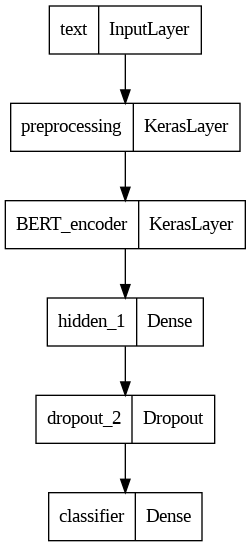

In [42]:
tf.keras.utils.plot_model(classifier_model)

In [33]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.metrics.CategoricalAccuracy()

In [43]:
X = partition_df.drop(['Label'], axis=1)
y = partition_df['Label']

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import warnings
import numpy as np
warnings.filterwarnings('ignore')

onehot_encoder = OneHotEncoder(sparse=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_onehot = onehot_encoder.fit_transform(np.array(y_train).reshape(-1,1))
y_test_onehot = onehot_encoder.transform(np.array(y_test).reshape(-1,1))

y_train_df = pd.DataFrame(y_train_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))
y_test_df = pd.DataFrame(y_test_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))

In [45]:
y_train_df

,Label_Charles Dickens,Label_Charlotte Bronte,Label_Edith Wharton,Label_Emily Bronte,Label_George Eliot,Label_Jane Austen
0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
955,0.0,0.0,1.0,0.0,0.0,0.0
956,0.0,0.0,1.0,0.0,0.0,0.0
957,0.0,0.0,1.0,0.0,0.0,0.0
958,0.0,0.0,0.0,0.0,1.0,0.0


In [53]:
epochs = 10
optimizer = tf.keras.optimizers.Adam(0.0001)

In [54]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [55]:
classifier_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [56]:
history = classifier_model.fit(X_train,y_train_df, batch_size=128, epochs=epochs, validation_data=(X_test, y_test_df))

Epoch 1/10
8/8 [==============================] - 19s 1s/step - loss: 0.0058 - categorical_accuracy: 0.9875 - val_loss: 0.4048 - val_categorical_accuracy: 0.9333
Epoch 2/10
8/8 [==============================] - 8s 951ms/step - loss: 0.0057 - categorical_accuracy: 0.9990 - val_loss: 0.3832 - val_categorical_accuracy: 0.9417
Epoch 3/10
8/8 [==============================] - 8s 1s/step - loss: 0.0054 - categorical_accuracy: 0.9990 - val_loss: 0.3831 - val_categorical_accuracy: 0.9333
Epoch 4/10
8/8 [==============================] - 9s 1s/step - loss: 0.0076 - categorical_accuracy: 0.9979 - val_loss: 0.4578 - val_categorical_accuracy: 0.9250
Epoch 5/10
8/8 [==============================] - 9s 1s/step - loss: 0.0045 - categorical_accuracy: 0.9969 - val_loss: 0.3784 - val_categorical_accuracy: 0.9417
Epoch 6/10
8/8 [==============================] - 8s 964ms/step - loss: 0.0029 - categorical_accuracy: 0.9990 - val_loss: 0.3567 - val_categorical_accuracy: 0.9500
Epoch 7/10
8/8 [===========

In [76]:
from tensorflow.keras.utils import to_categorical

In [78]:
y_pred = to_categorical(np.argmax(classifier_model.predict(X_test), axis=-1))

8/8 [==============================] - 1s 156ms/step


In [79]:
y_pred

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [80]:
acc = accuracy_score(y_pred, y_test_df)
precision = precision_score(y_pred, y_test_onehot, average='macro')
recall = recall_score(y_pred, y_test_onehot, average='macro')
f1 = f1_score(y_pred, y_test_onehot, average='macro')
roc_auc = roc_auc_score(y_test_onehot, y_pred, average='macro')

In [82]:
print("Average Accuracy: {}".format(acc))
print("Average Precision: {}".format(precision))
print("Average Recall: {}".format(recall))
print("Average F1: {}".format(f1))
print("Average ROC AUC: {}".format(roc_auc))

Average Accuracy: 0.9458333333333333
Average Precision: 0.9465236274446801
Average Recall: 0.9463038848866577
Average F1: 0.9460698238758353
Average ROC AUC: 0.9678226909254906
